# Predict time needed to complete a food delivery request

The goal is to predict the total time needed to complete a food delivery request, which is the time between 'created_at' and 'actual_delivery_time'. The variable 'created_at' is the time a customer makes an order through an app. The variable 'actual_delivery_time' is the time the customer receives the food order. 

### Import packgaes 

In [2]:
#basic dataframe manipulation and plotting
import pandas as pd #for manipulating dataframe
import numpy as np #for manipulating numbers
import matplotlib.pyplot as plt #for plotting
import seaborn as sns

#funcitons for dealing with categorical NaNs
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

#a function for normalizing the data
from sklearn import preprocessing

##ML
from sklearn.linear_model import Ridge, ElasticNet, Lasso, LinearRegression #linear models
from sklearn.neural_network import MLPRegressor #nonlinear model
from sklearn.metrics import mean_squared_error #calculate test error of models
from sklearn.model_selection import GridSearchCV #use gridsearch approach for specified parameter values

# just use this simple imputer to get mean of continuous features; for discrete features just create a 
# separate level for missing data
from sklearn.impute import SimpleImputer

#import my own functions
%run ML_funcs.ipynb

### Specify variables

In [3]:
#Specify variables
tz1 ='UTC'
tz2 = 'US/Pacific'
random_seed = 0
train_data_fname = "./historical_data.csv"
test_data_fname = "./predict_data.csv"

### Load data

In [4]:
train_data = pd.read_csv(train_data_fname)
test_data = pd.read_csv(test_data_fname)

## Data preprocessing

In [5]:
#check out data
#train_data.head()
train_data.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration'],
      dtype='object')

In [6]:
#train_data.describe()

In [7]:
#test_data.head()

In [8]:
#check NA values
train_data.isnull().sum() 

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64

In [9]:
#check NA values
test_data.isnull().sum() 

market_id                                        250
created_at                                         0
store_id                                           0
store_primary_category                          1343
order_protocol                                   283
total_items                                        0
subtotal                                           0
num_distinct_items                                 0
min_item_price                                     0
max_item_price                                     0
total_onshift_dashers                           4633
total_busy_dashers                              4633
total_outstanding_orders                        4633
estimated_order_place_duration                     0
estimated_store_to_consumer_driving_duration      11
delivery_id                                        0
platform                                           0
dtype: int64

In [10]:
# get rid of 7 data points with missing delivery time! these are useless
train_data = train_data.dropna(subset=['actual_delivery_time']).reset_index(drop = True)

# drop the delivery id and platform columns in test df; these are not in training data
test_data = test_data.drop(['delivery_id','platform'], axis = 1)

In [11]:
# only store_id has values in test data not seen in train data
unique_array_train = train_data.store_primary_category.unique()

# print(train_data.store_id.unique())
print(len(unique_array_train))

unique_array_test = test_data.store_primary_category.unique()

# print(train_data.store_id.unique())
print(len(unique_array_test))

len([i for i in unique_array_test if i in unique_array_train])

75
72


71

1802


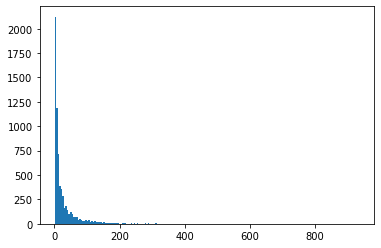

In [12]:
# many store ids don't even have that many data points each...maybe just don't use this variable in training...
print((train_data.store_id.value_counts().values < 5).sum())

plt.hist(train_data.store_id.value_counts(), bins=200);
plt.show()

In [13]:
# impute the missing values for continuous features with the mean
train_continuous = train_data.drop(['market_id','created_at','actual_delivery_time',
                                    'store_id','store_primary_category','order_protocol'], 
                                   axis=1)

test_continuous = test_data.drop(['market_id','created_at',
                                    'store_id','store_primary_category','order_protocol'], 
                                   axis=1)

In [14]:
print(train_continuous.shape)
print(test_continuous.shape)

(197421, 10)
(54778, 10)


In [15]:
imputer = SimpleImputer(strategy='mean')

# fit imputation model on training data
imputer.fit(train_continuous)

# impute missing data
train_imputed = imputer.transform(train_continuous)
test_imputed = imputer.transform(test_continuous)

train_continuous_imputed = train_continuous.copy()
train_continuous_imputed[:] = train_imputed

test_continuous_imputed = test_continuous.copy()
test_continuous_imputed[:] = test_imputed

# put imputed continuous columns back to the original dataframes
train_data = train_data.combine_first(train_continuous_imputed)
test_data = test_data.combine_first(test_continuous_imputed)

In [16]:
# for categorical variables, convert to dummy code? and just make the NaN another level in each feature!
#NaN for categorical data will just be stored at another level in the categories

# for categories that are only in test data and not in train data, it is set to -1 for now...
# this only happens for store_id -- decided to remove store_id 

In [17]:
# encode each categorical variable as integers! account for all unique values in both test and train set! 
train_cat = train_data[['market_id','store_primary_category','order_protocol']]#'store_id'
test_cat = test_data[['market_id','store_primary_category','order_protocol']]#,'store_id'

train_cat = train_cat.astype(str)
test_cat = test_cat.astype(str)


enc = OrdinalEncoder(dtype = int, handle_unknown = 'use_encoded_value',unknown_value=-1)

# fit encoder on training data
enc.fit(train_cat)

# trasnform
train_cat[:] = enc.transform(train_cat)
test_cat[:] = enc.transform(test_cat)

# put columns back to the original dataframes
train_data = train_cat.combine_first(train_data)
test_data = test_cat.combine_first(test_data)

In [18]:
##Now we have filled all the NaN values

In [19]:
train_data.isnull().sum()

actual_delivery_time                            0
created_at                                      0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
market_id                                       0
max_item_price                                  0
min_item_price                                  0
num_distinct_items                              0
order_protocol                                  0
store_id                                        0
store_primary_category                          0
subtotal                                        0
total_busy_dashers                              0
total_items                                     0
total_onshift_dashers                           0
total_outstanding_orders                        0
dtype: int64

In [20]:
test_data.isnull().sum()

created_at                                      0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
market_id                                       0
max_item_price                                  0
min_item_price                                  0
num_distinct_items                              0
order_protocol                                  0
store_id                                        0
store_primary_category                          0
subtotal                                        0
total_busy_dashers                              0
total_items                                     0
total_onshift_dashers                           0
total_outstanding_orders                        0
dtype: int64

In [21]:
##check data again

In [22]:
train_data.shape

(197421, 16)

In [23]:
test_data.shape

(54778, 15)

In [24]:
#train_data.describe()

In [25]:
#test_data.describe()

In [26]:
# get rid of outliers..etc
# can't do this for test data
# do this for duration! 
# some other outliers in the training data: negative values for price, negative values for number of dashers, etc
# I do not remove those outliers because they may appear in test data!

In [27]:
def addColumns(input_data, test = False):

    if test == False:
        duration = pd.to_datetime(input_data['actual_delivery_time'])-pd.to_datetime(input_data['created_at'])
        input_data['total_duration']=duration.dt.total_seconds()
        
    
    input_data['available_dasher']=input_data['total_onshift_dashers']-input_data['total_busy_dashers']

    test = pd.to_datetime(input_data['created_at'])
    input_data['day_of_week']=test.dt.dayofweek

    input_data['UStime'] = pd.to_datetime(input_data['created_at']).dt.tz_localize(tz1).dt.tz_convert(tz2)
    input_data['time_of_day']=input_data['UStime'].dt.strftime("%H").astype(int)

    input_data['week_sin'] = np.sin((input_data['day_of_week']+1)*2*np.pi/7)
    input_data['week_cos'] = np.cos((input_data['day_of_week']+1)*2*np.pi/7)

    input_data['day_sin'] = np.sin(input_data['time_of_day']*2*np.pi/24)
    input_data['day_cos'] = np.cos(input_data['time_of_day']*2*np.pi/24)
    
    return input_data

In [28]:
train_data = addColumns(train_data)
test_data  = addColumns(test_data, test = True)

In [29]:
#train_data.describe()

In [30]:
train = train_data.drop(['UStime','time_of_day','day_of_week','actual_delivery_time','created_at'], axis=1) 
test = test_data.drop(['UStime','time_of_day','day_of_week','created_at'], axis=1) 

In [31]:
train.shape

(197421, 20)

In [32]:
test.shape

(54778, 19)

In [33]:
# # get rid of total duration outliers! 
total_duration_outlier = (np.mean(train['total_duration'])+np.std(train['total_duration'])*6)
train=train[train['total_duration']<total_duration_outlier] # remove values that are above 6STD from mean

In [34]:
train.total_duration.describe()

count    197418.000000
mean       2861.582323
std        1164.087414
min         101.000000
25%        2104.000000
50%        2660.000000
75%        3381.000000
max       57032.000000
Name: total_duration, dtype: float64

In [35]:
# convert categorial to onehot! 
# and construct the full training matrix from both continuous and categorical matrices

enc_onehot = OneHotEncoder(handle_unknown='ignore', sparse = False)
enc_onehot.fit(train[['market_id','store_primary_category','order_protocol']])#'store_id'

train_cat_mat = enc_onehot.transform(train[['market_id','store_primary_category','order_protocol']])#'store_id'
test_cat_mat = enc_onehot.transform(test[['market_id','store_primary_category','order_protocol']])#'store_id'

In [36]:
test_cat_mat.shape

(54778, 90)

In [37]:
train_cat_mat.shape

(197418, 90)

In [38]:
# get the continuous matrix matrix!

train_duration = train['total_duration'].values
train = train.drop(['total_duration'],axis=1, errors='ignore')

train_cont_mat = train.drop(['market_id','store_primary_category','order_protocol'], axis=1)#,'store_id'
train_cont_vairables = train_cont_mat.columns
train_cont_mat = train_cont_mat
test_cont_mat = test.drop(['market_id','store_primary_category','order_protocol'], axis=1).values#,'store_id'

In [39]:
train.columns

Index(['estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'market_id',
       'max_item_price', 'min_item_price', 'num_distinct_items',
       'order_protocol', 'store_id', 'store_primary_category', 'subtotal',
       'total_busy_dashers', 'total_items', 'total_onshift_dashers',
       'total_outstanding_orders', 'available_dasher', 'week_sin', 'week_cos',
       'day_sin', 'day_cos'],
      dtype='object')

In [40]:
test.columns

Index(['estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'market_id',
       'max_item_price', 'min_item_price', 'num_distinct_items',
       'order_protocol', 'store_id', 'store_primary_category', 'subtotal',
       'total_busy_dashers', 'total_items', 'total_onshift_dashers',
       'total_outstanding_orders', 'available_dasher', 'week_sin', 'week_cos',
       'day_sin', 'day_cos'],
      dtype='object')

In [41]:
# combine continuous and categorical matrices into the complete mtr
train_mat = np.concatenate((train_cont_mat,train_cat_mat),axis=1)
test_mat = np.concatenate((test_cont_mat,test_cat_mat),axis=1)
print(train_mat.shape,test_mat.shape)

(197418, 106) (54778, 106)


In [41]:
#normalize the continuous variables for Lasso
normalized_cont_train = preprocessing.normalize(train_cont_mat)
normalized_cont_test = preprocessing.normalize(test_cont_mat)
train_norm_mat = np.concatenate((normalized_cont_train,train_cat_mat),axis=1)
test_norm_mat = np.concatenate((normalized_cont_test, test_cat_mat), axis = 1)
print(train_norm_mat.shape,test_norm_mat.shape)

(197418, 106) (54778, 106)


## Train and test models -- models selection

In [ ]:
# build models and test

In [44]:
#X = train.iloc[:,np.r_[0:2]]
X = train_mat
y = train_duration

In [45]:
splits=getSplitsStratKFold(
                    X,
                    y,
                    n_splits = 10, #how many splits
                    n_repeats = 1, # how many times to repeat this to get different splits
                    stratified = False, # for unbalanced categorical data
                    seed = 0)

In [46]:
Xlasso = train_norm_mat
ylasso = train_duration

splitslasso=getSplitsStratKFold(
                    Xlasso,
                    ylasso,
                    n_splits = 10, #how many splits
                    n_repeats = 1, # how many times to repeat this to get different splits
                    stratified = False, # for unbalanced categorical data
                    seed = 0)

In [49]:
alphas = [0.01, 0.1,1, 10,100,1000,10000]#, 1, 10,100,1000

# RMSE since really bad errors are magnified compared to MAE

for ialpha in alphas:
    ridge_test_alphas = train_and_test(X = X,
                   y = y,
                   splits = splits,
                   model_class = Ridge,
                   score_func = mean_squared_error, # this is actualy RMSE; see train_and_test() doc
                   model_args={'random_state':random_seed,'alpha':ialpha}, # for passing parameters to model_class
                   #gridcv_params={'alpha':alphas}, # for cross-validatings different parameters
                   gridcv_args=None,
                   fit_args=None,
                   feature_norm = False, # whether to normalize each feature dimension prior to classification
                   return_models=False
                   )
    ridge_alpha_test_errors=[np.mean(abs(alpha_test_errors)) for alpha_test_errors in ridge_test_alphas['test_errors']]
    print('Ridge:',ialpha, np.mean(ridge_alpha_test_errors))
    
    
    lasso_test_alphas = train_and_test(X = Xlasso,
                   y = ylasso,
                   splits = splitslasso,
                   model_class = Lasso,
                   score_func = mean_squared_error, # this is actualy RMSE; see train_and_test() doc
                   model_args={'random_state':random_seed,'alpha':ialpha, 'max_iter':100000}, # for passing parameters to model_class
                   #gridcv_params={'alpha':alphas}, # for cross-validatings different parameters
                   gridcv_args=None,
                   fit_args=None,
                   feature_norm = False, # whether to normalize each feature dimension prior to classification
                   return_models=False
                   )
    lasso_test_alphas_errors=[np.mean(abs(alpha_test_errors)) for alpha_test_errors in lasso_test_alphas['test_errors']]
    print('Lasso:',ialpha, np.mean(lasso_test_alphas_errors))

Ridge: 0.01 697.82156082444
Lasso: 0.01 729.3061536815637
Ridge: 0.1 697.8207485827821
Lasso: 0.1 730.4721356511047
Ridge: 1 697.8151173802883
Lasso: 1 770.7997521608838
Ridge: 10 697.797661120508
Lasso: 10 807.4977935012
Ridge: 100 697.8150858409894
Lasso: 100 824.4382139369533
Ridge: 1000 698.215177619151
Lasso: 1000 824.4382139369533
Ridge: 10000 700.1910595443063
Lasso: 10000 824.4382139369533


In [50]:
alphas = [0.01, 0.1,1, 10,100,1000]
ridge_results = train_and_test(X = X,
                   y = y,
                   splits = splits,
                   model_class = Ridge,
                   score_func = mean_squared_error, # this is actualy RMSE; see train_and_test() doc
                   model_args={'random_state':random_seed}, # for passing parameters to model_class
                   gridcv_params={'alpha':alphas}, # for cross-validatings different parameters
                   gridcv_args= None,
                   fit_args= None,
                   feature_norm = False, # whether to normalize each feature dimension prior to classification
                   return_models= True
                   )

In [51]:
ridge_results_test_errors=[np.mean(abs(itest_errors)) for itest_errors in ridge_results['test_errors']]
np.mean(ridge_results_test_errors)

698.215177619151

In [52]:
alphas = [0.01,0.1, 1]
lasso_results = train_and_test(X = Xlasso,
               y = ylasso,
               splits = splitslasso,
               model_class = Lasso,
               score_func = mean_squared_error, # this is actualy RMSE; see train_and_test() doc
               model_args={'random_state':random_seed, 'max_iter':100000}, # for passing parameters to model_class
               gridcv_params={'alpha':alphas}, # for cross-validatings different parameters
               gridcv_args= None,
               fit_args= None,
               feature_norm = False, # whether to normalize each feature dimension prior to classification
               return_models= True
               )

In [53]:
lasso_results_test_errors=[np.mean(abs(itest_errors)) for itest_errors in lasso_results['test_errors']]
np.mean(lasso_results_test_errors)

729.3061536815637

In [54]:
#from sklearn.neural_network import MLPRegressor
MLP_model = train_and_test(X = X,
                   y = y,
                   splits = splits,
                   model_class = MLPRegressor,
                   score_func = mean_squared_error,
                   model_args={'random_state':random_seed, 'max_iter':2000}, # for passing parameters to model_class
                   gridcv_params=None, # for cross-validatings different parameters
                   gridcv_args=None,
                   fit_args=None,
                   feature_norm = False, # whether to normalize each feature dimension prior to classification
                   return_models=False
                   )


In [55]:
MLP_model_test_errors=[np.mean(abs(ttest_errors)) for ttest_errors in MLP_model['test_errors']]
np.mean(MLP_model_test_errors)

670.1991257640832

### Plot the model comparison result

In [73]:
model_comp = pd.DataFrame({
    'test_errors':ridge_results_test_errors,
    'labels':['ridge']*10
})

lassodf = pd.DataFrame({
    'test_errors':lasso_results_test_errors,
    'labels':['lasso']*10
})

mlpdf = pd.DataFrame({
    'test_errors':MLP_model_test_errors,
    'labels':['mlp']*10
})


model_comp = model_comp.append(lassodf, ignore_index=True)
model_comp = model_comp.append(mlpdf, ignore_index=True)

In [74]:
model_comp.shape

(30, 2)

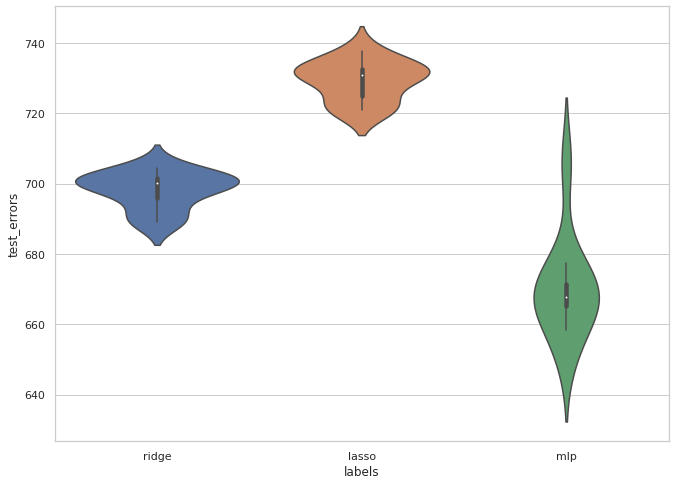

In [80]:
sns.set(rc={'figure.figsize':(11,8)})
sns.set_style("whitegrid")
sns.violinplot(x='labels', y='test_errors', data=model_comp)
plt.show()

## Train on all data and make prediction

In [119]:
MLP_model = MLPRegressor(random_state=random_seed, max_iter=2000)

In [120]:
MLP_model.fit(X,y)

MLPRegressor(max_iter=2000, random_state=0)

In [121]:
len(MLP_model.predict(test_mat))

54778

In [122]:
MLP_model.predict(test_mat)

array([3471.41334624, 2900.47491119, 2405.35304924, ..., 2585.32593648,
       3196.66847231, 2807.31478877])

In [ ]:
#check the weights for different variables to learn which variables are important in predicting total duration

In [90]:
Ridge_model = Ridge(random_state=random_seed, alpha = 10)

In [91]:
Ridge_model.fit(X,y)

Ridge(alpha=10, random_state=0)

In [113]:
all_variables = train_cont_vairables.tolist()+enc_onehot.get_feature_names().tolist()

In [115]:
datafram = pd.DataFrame({'variables':all_variables,
            'weights': Ridge_model.coef_})

In [117]:
datafram[datafram['weights']>10] #x0 = 'market_id', x1 = 'store_primary_category', x2 = 'order_protocol'

,variables,weights
4,num_distinct_items,24.479936
10,total_outstanding_orders,20.883659
12,week_sin,26.196704
13,week_cos,81.357691
16,x0_0,219.626825
18,x0_2,45.249250
23,x1_0,155.857964
31,x1_8,98.184280
32,x1_9,331.608502
35,x1_12,245.678630


In [118]:
datafram[datafram['weights']<-10] #x0 = 'market_id', x1 = 'store_primary_category', x2 = 'order_protocol'

,variables,weights
7,total_busy_dashers,-11.969611
9,total_onshift_dashers,-16.153278
14,day_sin,-191.544616
15,day_cos,-29.345621
17,x0_1,-106.273146
19,x0_3,-96.352500
20,x0_4,-50.793825
21,x0_5,-21.180538
24,x1_1,-40.349785
25,x1_2,-65.830518
